# Homework: Not So Basic Artificial Neural Networks

Your task is to implement a simple framework for convolutional neural networks training. While convolutional neural networks is a subject of lecture 3, we expect that there are a lot of students who are familiar with the topic.

In order to successfully pass this homework, you will have to:

- Implement all the blocks in `homework_modules.ipynb` (esp `Conv2d` and `MaxPool2d` layers). Good implementation should pass all the tests in `homework_test_modules.ipynb`.
- Settle with a bit of math in `homework_differentiation.ipynb`
- Train a CNN that has at least one `Conv2d` layer, `MaxPool2d` layer and `BatchNormalization` layer and achieves at least 97% accuracy on MNIST test set.

Feel free to use `homework_main-basic.ipynb` for debugging or as source of code snippets. 

Note, that this homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook with cnn trained
- `homework_modules.ipynb`
- `homework_differentiation.ipynb`

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython import display

In [2]:
# (re-)load layers
%run homework_modules.ipynb

In [3]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [4]:
import mnist
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

def preprocess_input(samples):
    if samples.ndim > 2:
        return np.expand_dims(samples, axis=1)
    else:
        if hasattr(ohe, 'feature_indices_'):
            return ohe.transform(samples.reshape(-1, 1))
        else:
            return ohe.fit_transform(samples.reshape(-1, 1))

X_train, y_train, X_val, y_val, X_test, y_test = map(preprocess_input, mnist.load_dataset())

In [5]:
n_samples, n_channels, height, width = X_train.shape

In [6]:
def show_learning_curve(log):
    display.clear_output()
    
    plt.plot(np.arange(len(log)), log)
    plt.xlabel('n_iterations')
    plt.ylabel('loss')
    plt.title('Learning curve')
    plt.show()
    
    print('Current loss:', loss)

In [7]:
model = Sequential()
model.add(Conv2d(n_channels, 16, 3))
model.add(MaxPool2d(2))
model.add(ReLU())
model.add(Conv2d(16, 32, 3))
model.add(MaxPool2d(2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(ReLU())
model.add(Linear(32 * height // 4 * width // 4, 64))
model.add(ReLU())
model.add(Linear(64, 10))
model.add(SoftMax())

criterion = ClassNLLCriterionUnstable()

In [8]:
from sklearn.metrics import accuracy_score

def compute_accuracy(y_true, y_pred):
    return accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))

In [9]:
log = []

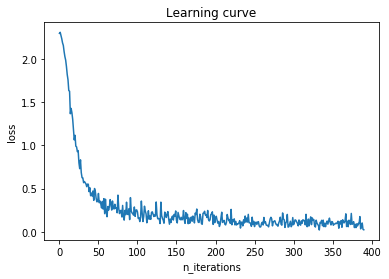

Current loss: 0.024672888299262178
0.967


In [10]:
n_epochs = 1
batch_size = 128

adam_config = {
    'learning_rate': 0.001,
    'beta1': 0.9,
    'beta2': 0.999,
    'epsilon': 10e-7
}
sgd_config = {
    'learning_rate': 0.01,
    'momentum': 0.9
}
optimizer_state = {}



for _ in range(n_epochs):
    for X_batch, y_batch in get_batches((X_train, y_train), batch_size):
        model.zeroGradParameters()
        
        preds = model.forward(X_batch)
        loss = criterion.forward(preds, y_batch)

        grads = criterion.backward(preds, y_batch)
        model.backward(X_batch, grads)
        
        sgd_momentum(model.getParameters(), model.getGradParameters(), sgd_config, optimizer_state)
        print('Iteration passed')
        log.append(loss)
        
    show_learning_curve(log)
    print(compute_accuracy(y_val[:1000], model.forward(X_val[:1000])))

Print here your accuracy on test set. It should be >97%. Don't forget to switch the network in 'evaluate' mode

In [13]:
model.evaluate()

In [14]:
compute_accuracy(y_test, model.forward(X_test))

0.9769